In [1]:


import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [2]:
!ls

 clean_tweet.csv     'feature_normal_tfidf_algo_comp(2).ipynb'
'data_vis(1).ipynb'   train_clean.csv


In [5]:
csv = 'train_clean.csv'
my_df = pd.read_csv(csv)
my_df.head()

,id,text,target
0,86426,she should ask few native americans what their...,1
1,90194,go home you re drunk,1
2,16820,amazon is investigating chinese employees who ...,0
3,62688,someone should vetaken this piece of shit to v...,1
4,43605,obama wanted liberals amp illegals to move int...,0


In [6]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 3 columns):
id        13240 non-null int64
text      13239 non-null object
target    13240 non-null int64
dtypes: int64(2), object(1)
memory usage: 310.4+ KB


In [8]:
len(my_df.text)

13240

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df['text'].values.astype('U'))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
len(cvec.get_feature_names())

17063

In [13]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text.values.astype('U'))
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text.values.astype('U'))
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()


In [14]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]


,negative,positive,total
the,5824,3250,9074
is,4244,2401,6645
to,4050,2269,6319
you,3614,1872,5486
and,3280,1894,5174
of,2460,1374,3834
are,2373,1281,3654
he,1984,1141,3125
that,1873,1174,3047
not,1931,1031,2962



# Zipf's Law

Zipf's Law is first presented by French stenographer Jean-Baptiste Estoup and later named after the American linguist George Kingsley Zipf. Zipf's Law states that a small number of words are used all the time, while the vast majority are used very rarely. There is nothing surprising about this, we know that we use some of the words very frequently, such as "the", "of", etc, and we rarely use the words like "aardvark" (aardvark is an animal species native to Africa). However, what's interesting is that "given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc."

In other words, the rth most frequent word has a frequency f(r) that scales according to $${f(r)} \propto \frac{1}{r^\alpha}$$ for $$\alpha \approx {1}$$

Let's see how the tweet tokens and their frequencies look like on a plot.


Text(0.5,1,'Top 500 tokens in tweets')

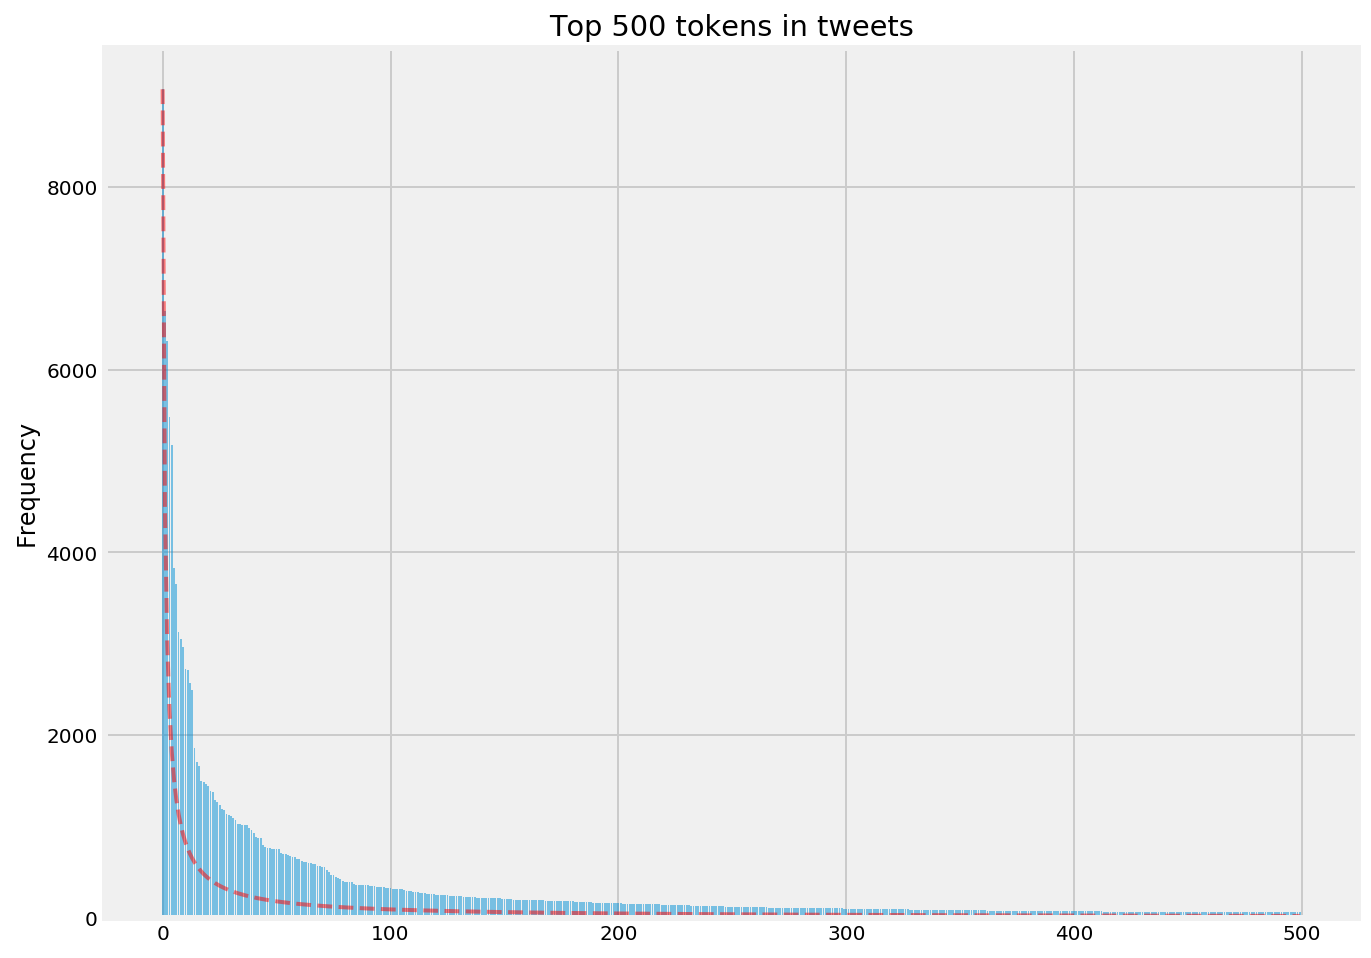

In [15]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')


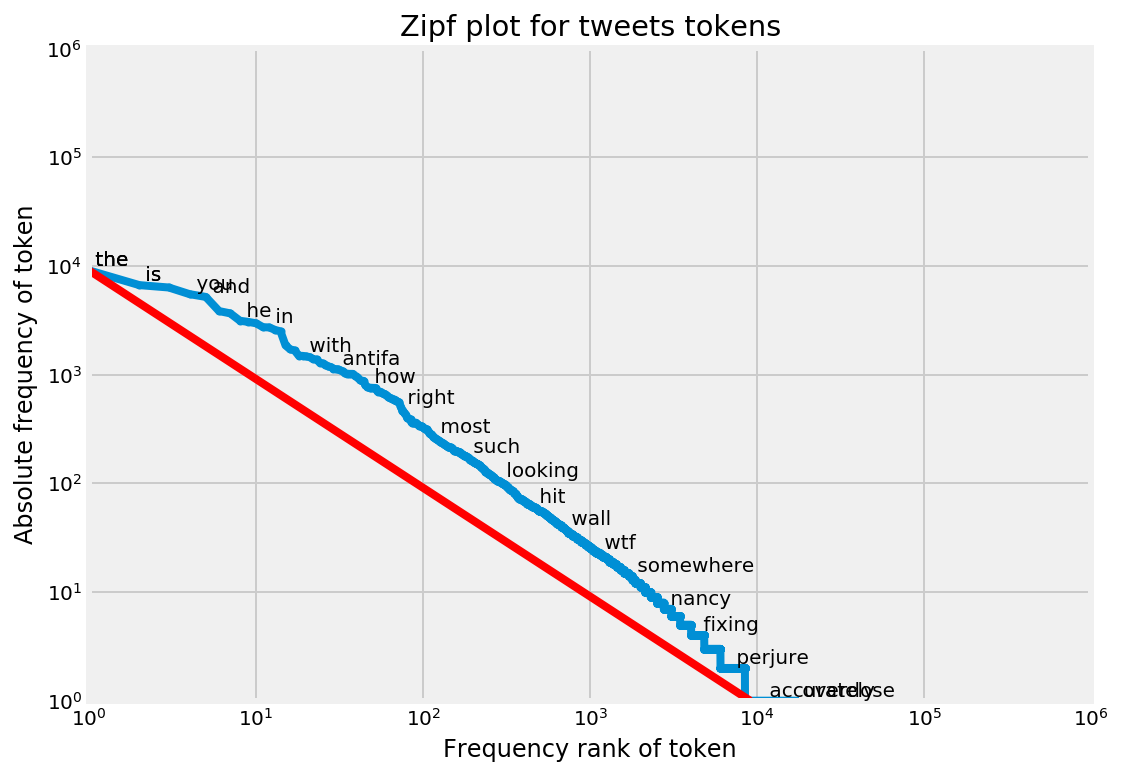

In [16]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")


In [18]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

In [19]:
term_freq_df = pd.read_csv('term_freq_df.csv',index_col=0, encoding='utf_8')


In [22]:
document_matrix = cvec.transform(my_df['text'].values.astype('U'))


In [23]:
%%time
neg_batches = np.linspace(0,6620,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1


735 entries' term freuquency calculated
1471 entries' term freuquency calculated
2206 entries' term freuquency calculated
2942 entries' term freuquency calculated
3677 entries' term freuquency calculated
4413 entries' term freuquency calculated
5148 entries' term freuquency calculated
5884 entries' term freuquency calculated
6620 entries' term freuquency calculated
CPU times: user 324 ms, sys: 340 ms, total: 664 ms
Wall time: 657 ms


In [24]:
%%time
pos_batches = np.linspace(6620,13239,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1


7355 entries' term freuquency calculated
8090 entries' term freuquency calculated
8826 entries' term freuquency calculated
9561 entries' term freuquency calculated
10297 entries' term freuquency calculated
11032 entries' term freuquency calculated
11768 entries' term freuquency calculated
12503 entries' term freuquency calculated
13239 entries' term freuquency calculated
CPU times: user 233 ms, sys: 378 ms, total: 611 ms
Wall time: 622 ms


In [25]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,4503,4571,9074
is,3353,3291,6644
to,3157,3162,6319
you,2739,2747,5486
and,2546,2627,5173
of,1947,1887,3834
are,1824,1830,3654
he,1608,1517,3125
that,1495,1552,3047
not,1511,1451,2962


Text(0.5,1,'Top 50 tokens in negative tweets')

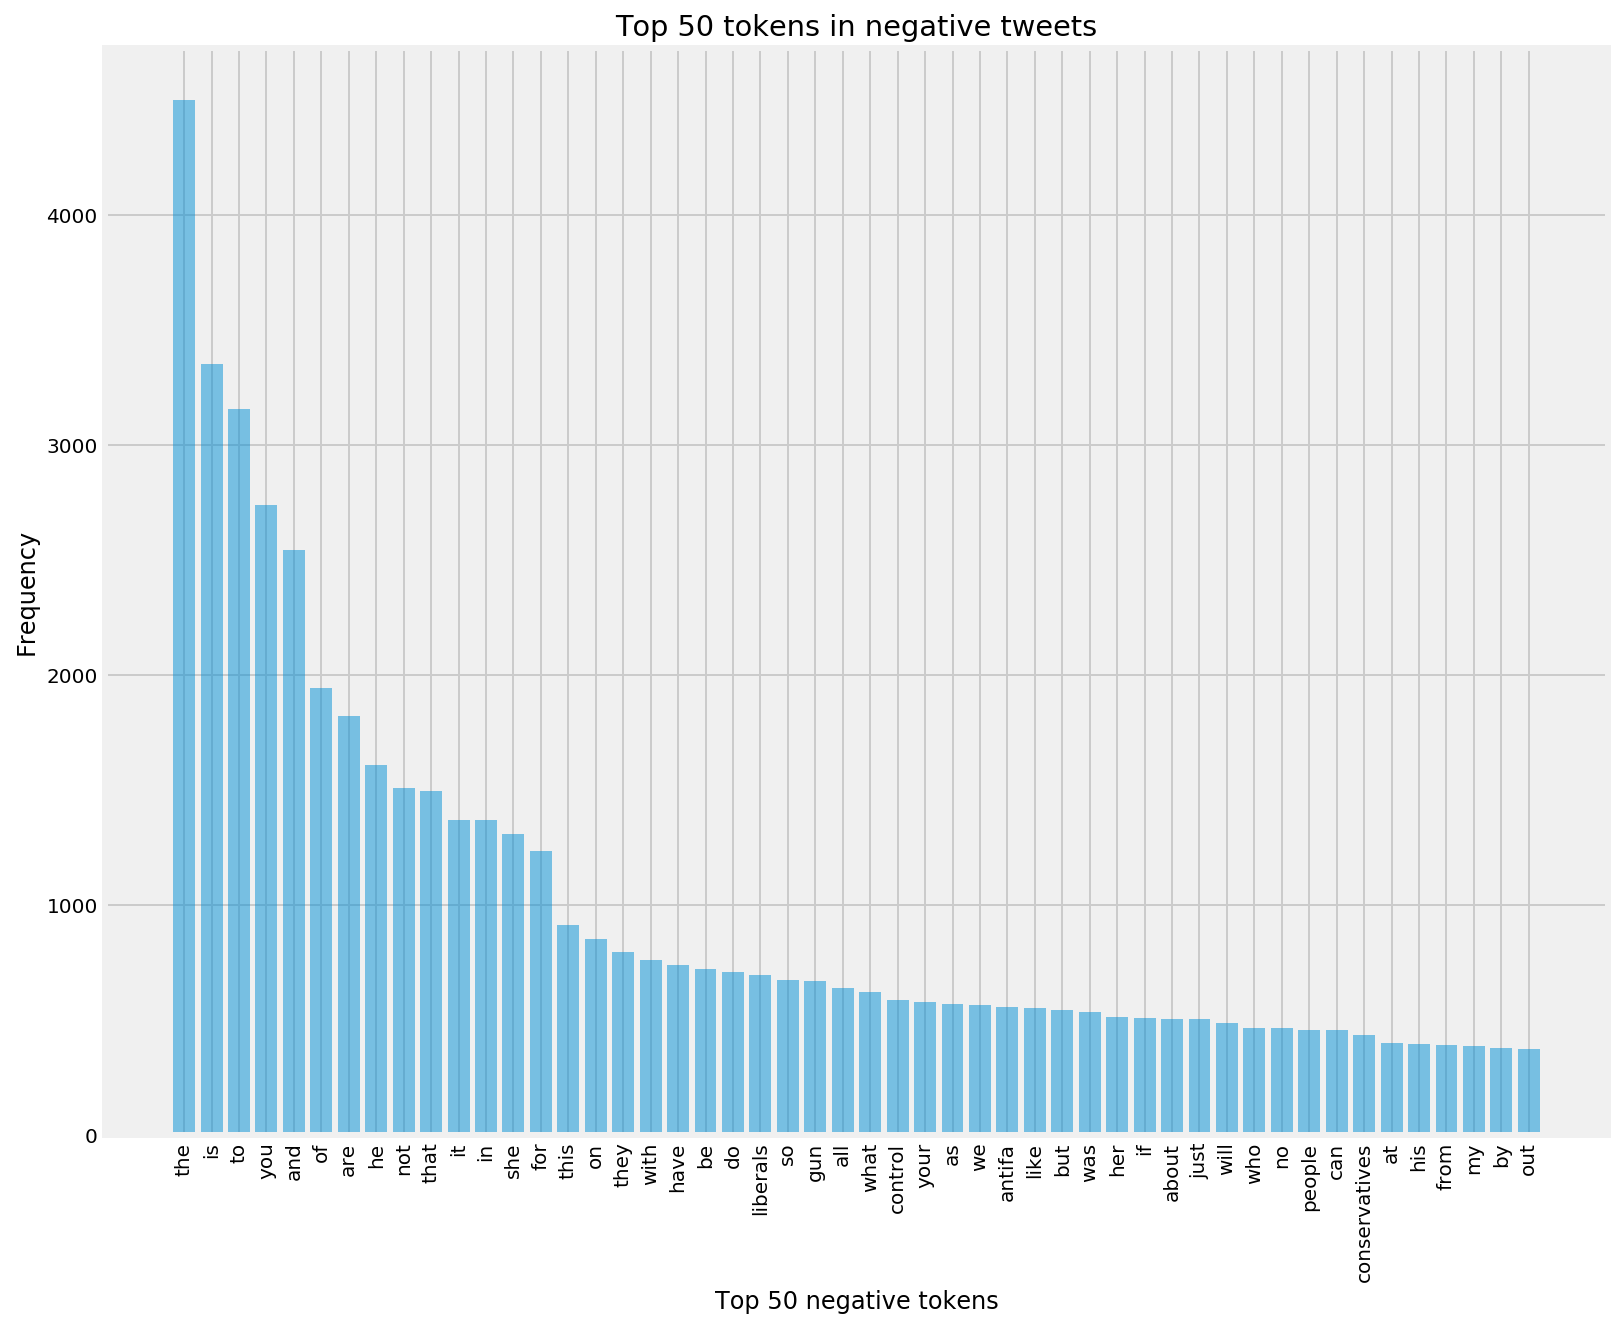

In [26]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Top 50 tokens in positive tweets')

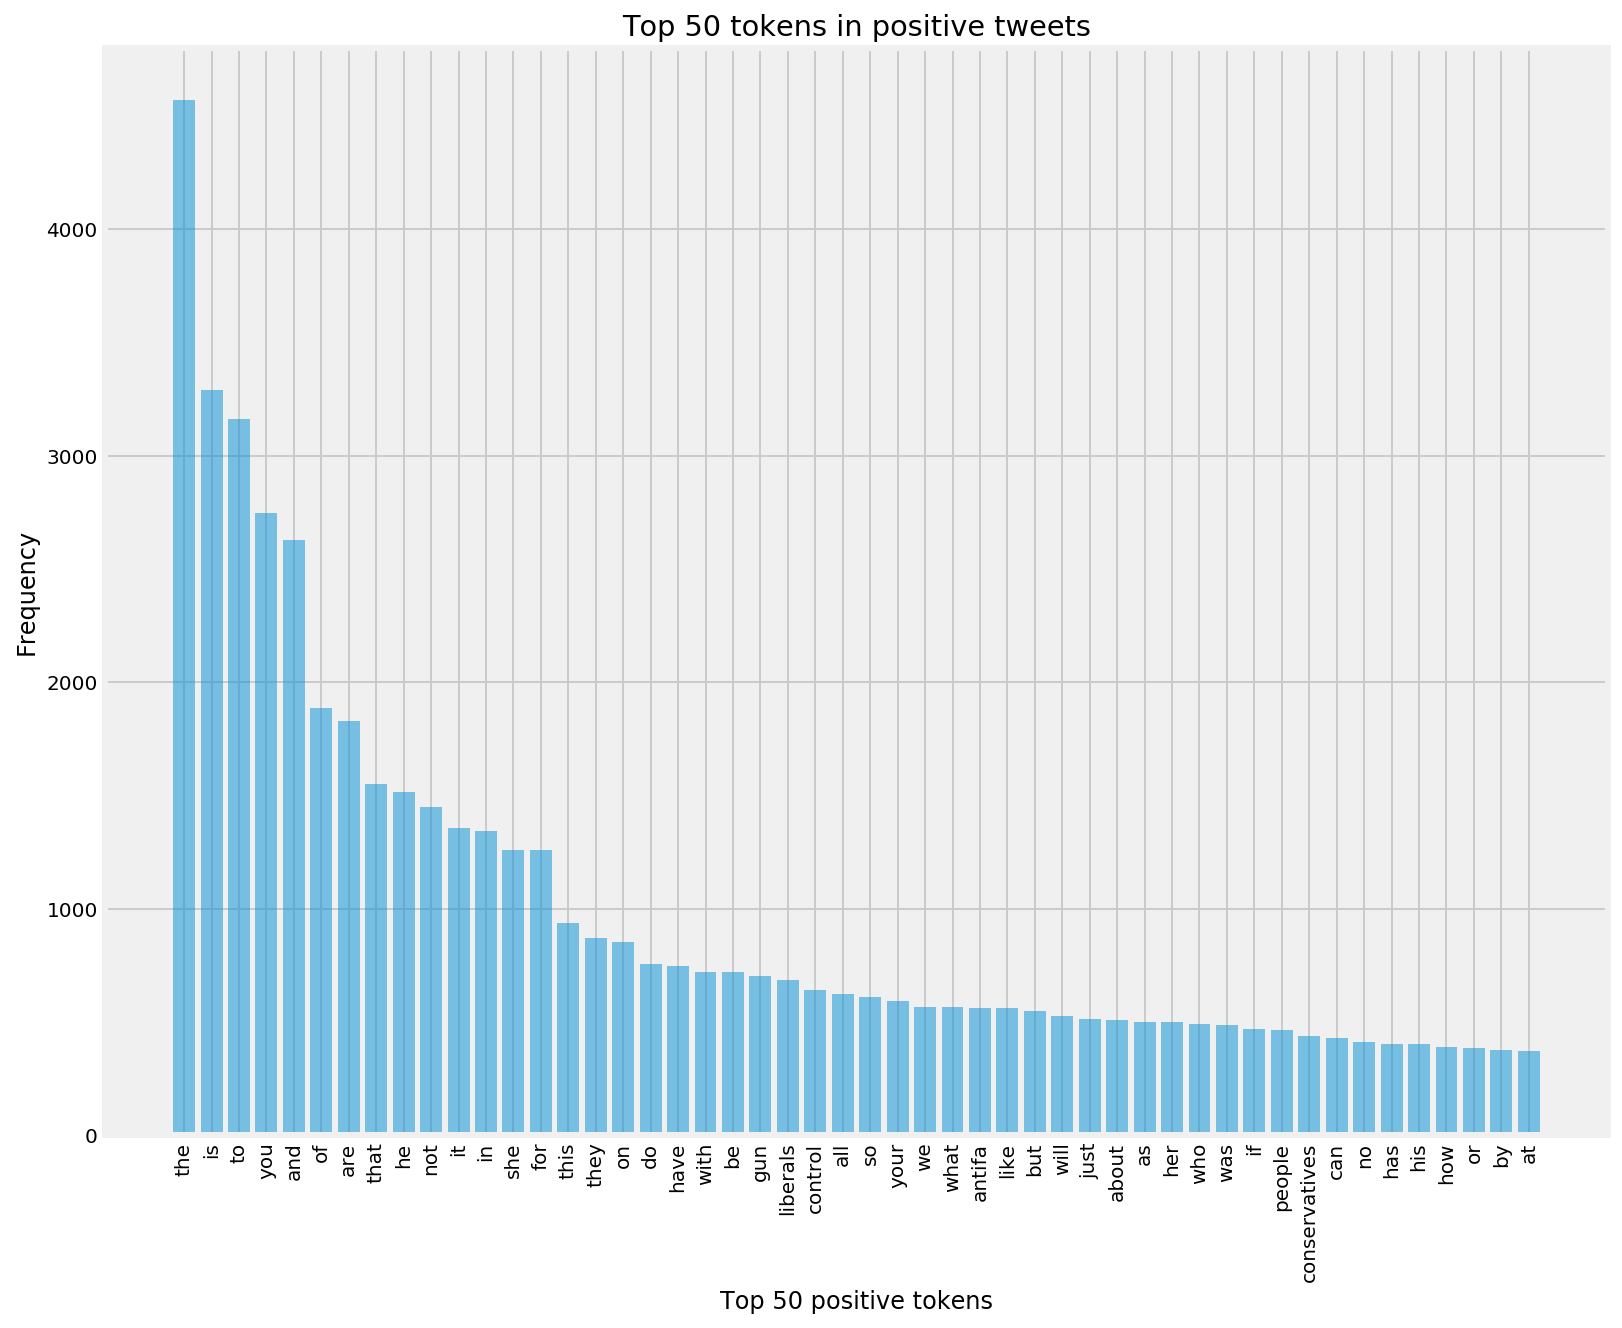

In [27]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,'Negative Frequency vs Positive Frequency')

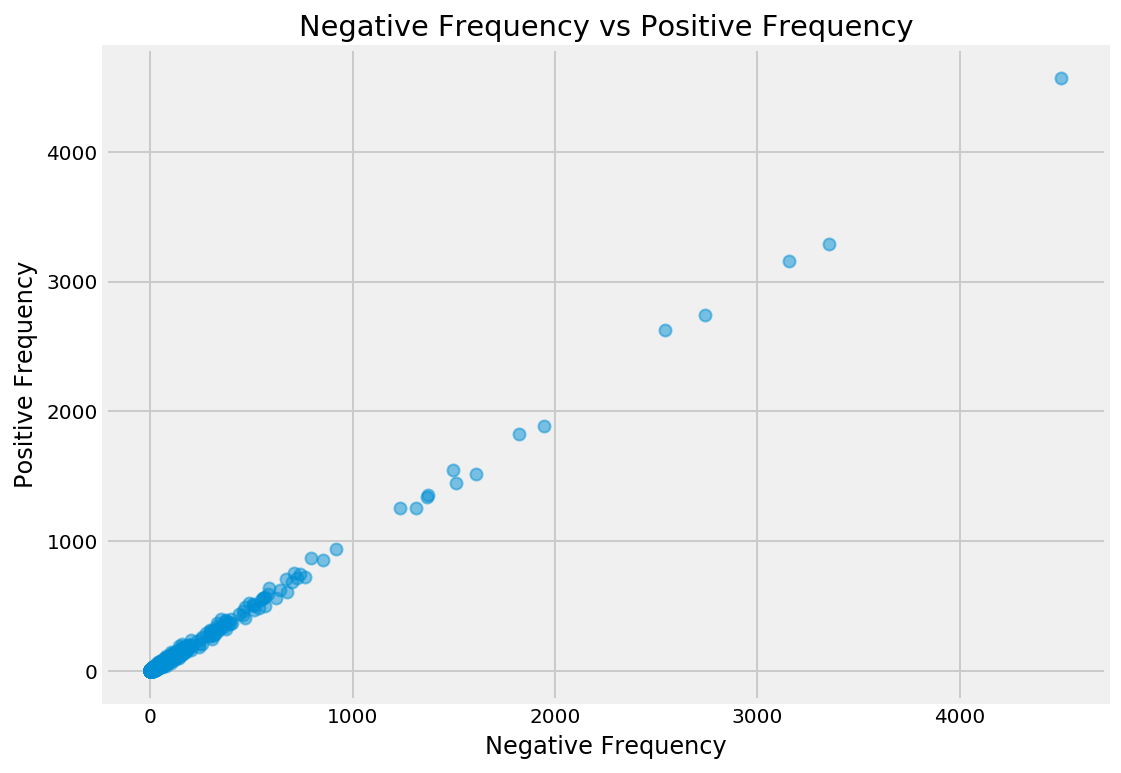

In [28]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')